# Z0 Data Analysis Workbook

This workbook was created to provide an outline of the data analysis required for the Z0 data analysis lab practical. This workbook should be considered as a staring point for the work, giving examples on how to read in the data products, plot the data and perform fits. The final assesment will be performed based on your modified version of this notebook alone so please expand on the starting point here, making sure to comment your work whereever possible to make it clear what is being done. Also please make sure that your final results for each of the requested values is made clear.

Also please remember to clearly label the axes on any plots produced and that error estimation is important!

### Import libraries and read in data

The first step here (as usual in python) is to import the libraries we need. In this case we are using rather "standard" scientific python libraries:

- iPython
- jupyter
- numpy
- scipy
- matplotlib

If you have got this far you must already have at least jupyter and ipython installed. However in order to set up a consistant python environment I would recommend you use the python package manager conda (https://docs.conda.io/projects/conda/en/latest/user-guide/getting-started.html) which should work on Windows, Mac and Linux.

In [55]:
#import fundamental libraries
import numpy as np
import math
import scipy.constants as const
from IPython.display import IFrame
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

from IPython.core.display import display_html
display_html("<style>.container { width:90% !important; }</style>")


This function reads in the provided data files (provided in raw text format) and formats them to extract the relevant particle and event-wise parameters. The output from this function is 2 data structures (in python list format), both of the same length. One contains a summary of the information of each event and the other the list of particles detected in each event and their properties.

In [110]:
###Function to read in events from the ASCII data files
def read_events(fname):
    file_content=[]
    particle_content=[]
    event_content=[]
    line_content=[]
    muon_max = 0
    
    #loop over the file on a line by line basis
    for line in open(fname):
        # If the line starts with a "#" it's a comment.
        if(line.startswith("#")):
            continue
        
        # If the line has 1 entry it contains only the number of particles in the following event. 
        # Information in this line is not saved but used to define the event structures
        
        if len(line.split())==1:
            number_of_particles=int(line.split()[0])
            #initialize counter of particles and event content
            count=0
            event_content=[]
            #initialize event variables
            n_el=0
            n_mu=0
            n_had=0
            n_part=0
            passes_hadron_selection=0
            passes_muon_selection=0
            max_pt=0.
            continue
            
        #when there are more entries then it's a particle. the information about its momentum and mass are saved in a
        #structured array. another couple of variables are also added
        if len(line.split())!=1 and count<number_of_particles:
            
            # Structure containing the information about each particle within the event
            line_content=np.zeros(1, dtype = [('px','float64'),('py', 'float64'),('pz', 'float64'), # Momentum components
                                              ('m', 'float64'), # Particle mass
                                              ('p', 'float64'), # Total momentum
                                              ('e', 'float64'), # Total energy
                                              ('pt', 'float64'),('et', 'float64'), # Transverse momentum and energy
                                              ('ez', 'float64')]) # Longitudinal energy
            
            event_var=np.zeros(1, dtype = [('n_el','float64'), # Number of EM particles
                                           ('n_mu','float64'), # Number of muons
                                           ('n_had','float64'), # Number of hadrons
                                           ('n_part','float64'), # Number of particles total
                                           ('max_pt','float64'),# Maximum particle transverse momentum
                                           ('muon_max','float64'), # most energetic muon REMOVE!
                                          ])
                            
            
            # Copy across the particle information from the line read in
            num, px, py, pz, m = [float(item) for item in line.split()]

            # Copy everything into our particle information structure
            line_content['px'] = px
            line_content['py'] = py
            line_content['pz'] = pz
            line_content['m'] = m
            line_content['p']=math.sqrt(px * px + py * py + pz * pz)
            line_content['pt']=math.sqrt(px * px + py * py)
            line_content['e']=math.sqrt(px * px + py * py + pz * pz)
            line_content['et']=math.sqrt(px * px + py * py)
            line_content['ez']=math.sqrt(pz * pz)
            event_content.append(line_content)


            if abs(abs(line_content['m'][0])-0.106)<0.001: # This is a muon
                n_mu+=1
                if line_content['e'] > muon_max: # REMOVE
                    muon_max = line_content['e']
            elif abs(abs(line_content['m'][0])-0.000)<0.001: n_el+=1 # Photon (based on mass)
            elif abs(abs(line_content['m'][0])-0.140)<0.001: n_had+=1 # Hadron (based on mass)

            n_part=number_of_particles
            if line_content['pt'][0]>max_pt: max_pt=line_content['pt'][0]
            if count==number_of_particles-1: 
                    event_var['n_el']=n_el
                    event_var['n_mu']=n_mu
                    event_var['n_had']=n_had
                    event_var['n_part']=n_part
                    event_var['max_pt']=max_pt

                    event_var['muon_max']=muon_max #REMOVE
                    muon_max=0
                    
                    file_content.append(event_var)
                    particle_content.append(event_content)

        count+=1
                    
    return np.array(file_content), particle_content

In [135]:
#what does an event look like? let's see 
#we use only one file for this test
hadrons_name='hadrons.dat'
muons_name='muons.dat'
# input_name='hadrons.dat'
# input_name='hadrons.dat'
#we read all events with the class above.
event_properties_hadrons, particle_properties_hadrons = read_events(hadrons_name)
event_properties_muons, particle_properties_muons = read_events(muons_name)

## cut for hadrons

In [178]:
def make_hadron_cut(event_properties, particle_properties, energy):
    selection = np.zeros(len(event_properties), dtype=bool)
    for ind, event in enumerate(event_properties):
        total_energy_of_event = sum([
            particle_properties[ind][_]["e"] for _ in range(len(particle_properties[ind]))
        ])
        if (event["n_part"] >= 13
            and event["n_part"] < 100000
            and total_energy_of_event/energy < 1.5
            and total_energy_of_event/energy > 0.5
            ):
            selection[ind] = True

    eff_hadrons = np.sum(selection) / len(event_properties)
    print("Efficiency hadrons: ", eff_hadrons)
    return selection



## cut for muons

In [180]:
def make_muon_cut(event_properties, particle_properties, energy):
    selection = np.zeros(len(event_properties), dtype=bool)
    for ind, event in enumerate(event_properties):
        total_energy_of_event = sum([
            particle_properties[ind][_]["e"]
            for _ in range(len(particle_properties[ind]))
        ])
        muon_energy_of_event = sum([
            particle_properties[ind][_]["e"]
            for _ in range(len(particle_properties[ind]))
            if abs(abs(particle_properties[ind][_]['m'][0])-0.106)<0.001
        ])
        if (event["n_part"] <= 9
            and event["n_mu"] >= 2
            and total_energy_of_event/91 < 1.6
            and total_energy_of_event/91 > 0.8
            and muon_energy_of_event/total_energy_of_event >= 0.6
        ):
            selection[ind] = True

    eff_muons = np.sum(selection) / len(event_properties)
    print("Efficiency muonen: ", eff_muons)
    return selection



### Exploring the dataset

Now we have the functions to read in the data we can take a look at it and see the effects of changing different cuts on the distributions and see how this will help us to pick the best classifying cuts to select the appropriate hadron and muon Z0 events.

In [138]:
input_data_file = "91gev.dat" # first define which energy range data we want to read in

# Then we get our data from the input file
data_events, data_particles = read_events(input_data_file)

#we retrieve the muon and hadron MC data
muon_mc_events, muon_mc_particles =read_events("muons.dat")
hadron_mc_events, hadron_mc_particles =read_events("hadrons.dat")

data_var = []
print(len(data_events), "events in data, ", len(muon_mc_events), "muon MC events, ", len(hadron_mc_events),"hadron MC events")

10000 events in data,  9969 muon MC events,  10000 hadron MC events


Efficiency hadrons:  0.4059
Efficiency muonen:  0.0208
Statistical uncertainty of data hadron selection is  0.00637102817447859
Statistical uncertainty of data muon selection is  0.0014422205101855957
Efficiency hadrons:  0.0
Efficiency muonen:  0.6076838198415087
Statistical uncertainty of muon mc hadron selection is  0.0
Statistical uncertainty of muon mc muon selection is  0.007783315488916019
Efficiency hadrons:  0.9964
Efficiency muonen:  0.0
Statistical uncertainty of hadron mc hadron selection is  0.009981983770774224
Statistical uncertainty of hadron mc muon selection is  0.0


/var/folders/fc/ccsxh4m96q14l36h694rwrkw0000gp/T/ipykernel_19698/1810008986.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_hadron_selection) / np.sum(muon_mc_hadron_selection))
/var/folders/fc/ccsxh4m96q14l36h694rwrkw0000gp/T/ipykernel_19698/1810008986.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_muon_selection) / np.sum(hadron_mc_muon_selection))


Text(0.5, 0, 'n_part')

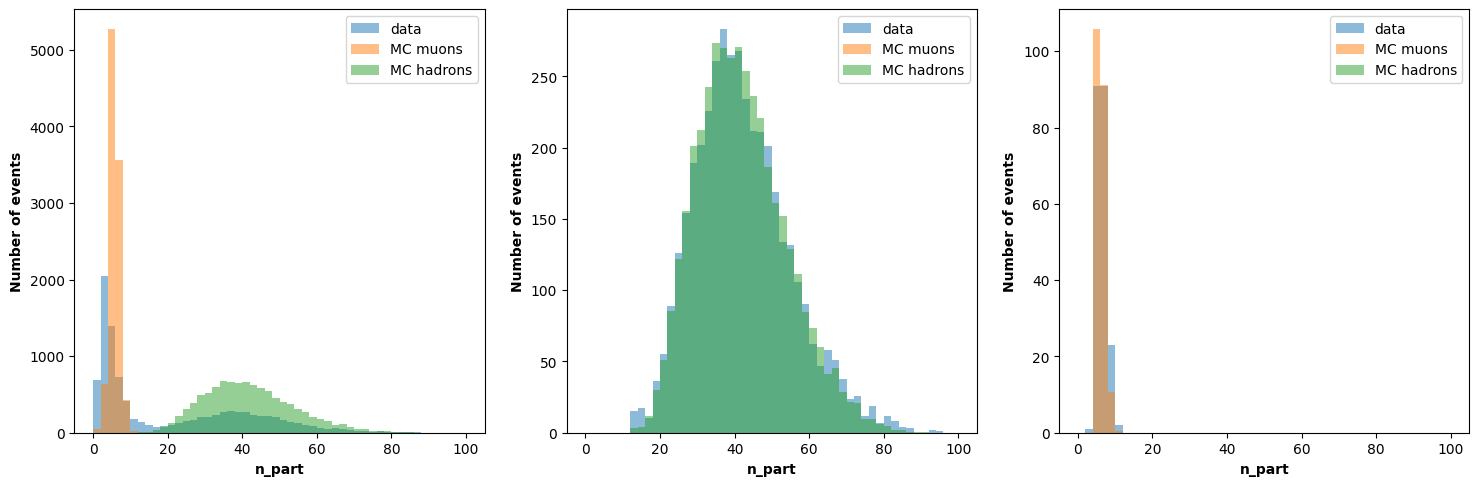

In [181]:
variable = "n_part" # The name of the variable we want to plot
xmin, xmax, nbins = 0., 100, 51 # And the binning of the histogram we want to make (min, max, number of bins)
binning_type = "linear" # And whether we want log or linear binning
energy = 91.33

# Define the figure we want to draw
figure, ((ax1, ax2, ax3)) = plt.subplots(1, 3,  figsize=(18,5.5))

# Make selections on data and store a bool of those passing
data_hadron_selection = make_hadron_cut(data_events, data_particles, energy)
data_muon_selection = make_muon_cut(data_events, data_particles, energy)

data_hadron_selection_unc_st = np.sqrt(len([event for event in data_hadron_selection if event]))/10000
data_muon_selection_unc_st = np.sqrt(len([event for event in data_muon_selection if event]))/10000
print("Statistical uncertainty of data hadron selection is ", data_hadron_selection_unc_st)
print("Statistical uncertainty of data muon selection is ", data_muon_selection_unc_st)

# Do same for MC muons
muon_mc_hadron_selection = make_hadron_cut(muon_mc_events, muon_mc_particles, energy)
muon_mc_muon_selection = make_muon_cut(muon_mc_events, muon_mc_particles, energy)

muon_mc_hadron_selection_unc_st = np.sqrt(len([event for event in muon_mc_hadron_selection if event]))/10000
muon_mc_muon_selection_unc_st = np.sqrt(len([event for event in muon_mc_muon_selection if event]))/10000
print("Statistical uncertainty of muon mc hadron selection is ", muon_mc_hadron_selection_unc_st)
print("Statistical uncertainty of muon mc muon selection is ", muon_mc_muon_selection_unc_st)

# and MC hadrons
hadron_mc_hadron_selection = make_hadron_cut(hadron_mc_events, hadron_mc_particles, energy)
hadron_mc_muon_selection = make_muon_cut(hadron_mc_events, hadron_mc_particles, energy)

hadron_mc_hadron_selection_unc_st = np.sqrt(len([event for event in hadron_mc_hadron_selection if event]))/10000
hadron_mc_muon_selection_unc_st = np.sqrt(len([event for event in hadron_mc_muon_selection if event]))/10000
print("Statistical uncertainty of hadron mc hadron selection is ", hadron_mc_hadron_selection_unc_st)
print("Statistical uncertainty of hadron mc muon selection is ", hadron_mc_muon_selection_unc_st)

# Define the bins for our histogram as an array of the bin boundaries
if binning_type is "log":
    bins = np.logspace(np.log10(xmin),np.log10(xmax), nbins)
else:
    bins = np.linspace(xmin, xmax, nbins)

# The first histogram we make is our data events vs the MC muon and hadron events with no cuts made
# When comparing histograms we weight MC so that integral is same as data
weight_muon = len(data_events) / len(muon_mc_events)
weight_hadron = len(data_events) / len(hadron_mc_events)

ax1.hist(data_events[:][variable], bins=bins, alpha=0.5, label="data")
ax1.hist(muon_mc_events[:][variable], bins=bins, alpha=0.5, label="MC muons")
ax1.hist(hadron_mc_events[:][variable], bins=bins, alpha=0.5, label="MC hadrons")
ax1.set_xscale(binning_type)
#ax1.set_yscale(binning_type)
ax1.set_ylabel("Number of events", weight="bold")
ax1.set_xlabel(variable, weight="bold")
ax1.legend()

# Next we make the same plot for events passing hadron cuts
weight_muon = np.ones(np.sum(muon_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection) / np.sum(muon_mc_hadron_selection))
weight_hadron = np.ones(np.sum(hadron_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection) / np.sum(hadron_mc_hadron_selection))

ax2.hist(data_events[data_hadron_selection][variable], bins=bins, alpha=0.5, label="data")
ax2.hist(muon_mc_events[muon_mc_hadron_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
ax2.hist(hadron_mc_events[hadron_mc_hadron_selection][variable], weights=weight_hadron, 
         bins=bins, alpha=0.5, label="MC hadrons")
ax2.set_xscale(binning_type)
#ax2.set_yscale(binning_type)
ax2.set_ylabel("Number of events", weight="bold")
ax2.set_xlabel(variable, weight="bold")
ax2.legend()

# And finally for events passing muon cuts
weight_muon = np.ones(np.sum(muon_mc_muon_selection)) * \
                (np.sum(data_muon_selection) / np.sum(muon_mc_muon_selection))
weight_hadron = np.ones(np.sum(hadron_mc_muon_selection)) * \
                (np.sum(data_muon_selection) / np.sum(hadron_mc_muon_selection))

ax3.hist(data_events[data_muon_selection][variable], bins=bins, alpha=0.5, label="data")
ax3.hist(muon_mc_events[muon_mc_muon_selection][variable], weights=weight_muon, 
         bins=bins, alpha=0.5, label="MC muons")
ax3.hist(hadron_mc_events[hadron_mc_muon_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
ax3.set_xscale(binning_type)
ax3.legend()

ax3.set_ylabel("Number of events", weight="bold")
ax3.set_xlabel(variable, weight="bold")


In [18]:
#Calculate the cross section for hadrons


In [19]:
#Calculate the cross section for muons

### Fitting the Breit Wigner PDF

The final functions provided calculate the required "r" parameter and perform the integration required to compute the corrected Breit-Wigner PDF. The funtions are provided to perform the fit to the cross section measurements at the 3 energies, calculated in the previous sections.

In [20]:
from scipy.integrate import quad
#definition of stuff you don't really need to look into, here we define the functions for the convolution between the
#breit-wigner and the gaussian
def radcorr(z,s):
    me2    = 0.0000002611200
    alphpi = 0.0023228196
    zeta2  = 1.644934
    cons1  = -2.16487
    cons2  = 9.8406
    cons3  = -6.26
    fac2   = 1.083
    l      = math.log(s/me2)
    beta   = 2.*alphpi*(l-1.)
    del1vs = alphpi*((3./2.)*l+2.*zeta2-2.)
    del2vs = pow(alphpi,2.)*(cons1*pow(l,2.)+cons2*l+cons3)
    delvs  = 1.+del1vs+del2vs
    del1h  = -alphpi*(1.+z)*(l-1.)
    delbh  = pow(alphpi,2.)*(1./2.)*pow((l-1.),2.)*((1.+z)*(3.*math.log(z)-4.*math.log(1.-z))-(4./(1.-z))*math.log(z)-5.-z)
    rad    = beta*pow((1.-z),beta-1.)*delvs+del1h+delbh
    rad *=fac2
    return rad

# Breit-Widgner distribution
def bw(s, s0, g2, m2):
    return s0*(s*g2)/(pow(s-m2,2)+m2*g2)

def bw2(x,pars):
    return bw(pow(x,2),pars[0],pow(pars[1],2),pow(pars[2],2))

def integrand2(x, p0, p1, p2, p3):
    integrand = bw(x*p0,p1,p2,p3)
    integrand *= radcorr(x,p0)
    
    return integrand

def convolution(s,s0,g2,m2):
    
    if(s<60):
        print("s too small")
        return -1

    zmin=pow(60,2)/s
    zmax=0.9999999999
    result, error = quad(integrand2, zmin,zmax, args=(s,s0,g2,m2), epsrel=1e-6)
    return result

def convolution2(x, sigma, gamma, mass):
    y_est = []
    for xp in x:
        y_est.append(convolution(pow(xp,2), sigma, pow(gamma,2), pow(mass,2)))
    return y_est

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.048e-06                  │              Nfcn = 235              │
│ EDM = 5.05e-06 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

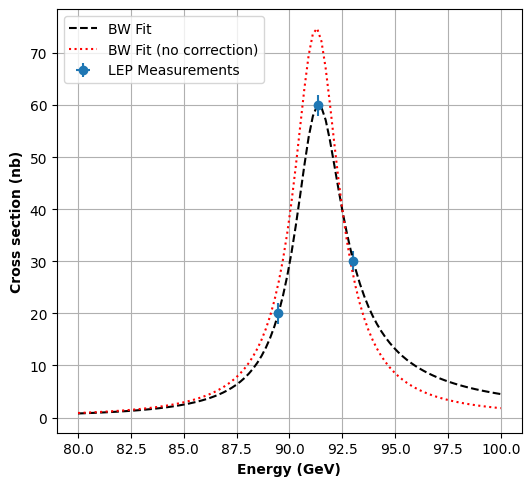

In [21]:
from iminuit import Minuit

#now we want to perform a fit for hadrons
#we have three energy-points
npoints=3
#here you need to declare the energy-vs-cross section and the errors from your estimation
x= [89.48,91.33,93.03]
y= [20,60,30] # These values are of course example guess values, replace them with your own
ex= [0.,0.,0.]
ey= [2,2,2] # These error values should also be replaced

def chi_squared(sigma, gamma, mass):
    expectation = np.array(convolution2(x, sigma, gamma, mass))
    return np.sum((expectation-np.array(y))**2/np.array(ey))

minuit = Minuit(chi_squared, sigma=70., gamma=5., mass=90.)
minuit.migrad()
minuit.hesse()
minuit.minos()

fit_parameters =  np.array([minuit.values[0], minuit.values[1], minuit.values[2]])
errors =  np.array([minuit.errors[0], minuit.errors[1], minuit.errors[2]])

# Make a plot of the best fit values in comparison to measurements
plt.figure(figsize=(6,5.5))
plt.errorbar(x, y, xerr=ex, yerr=ey, fmt="o", label="LEP Measurements")

# Evaluate our fitted function at lots of values of energy to make a line
# then draw it on top of the points
fit_x = np.linspace(80,100,100)
plt.plot(fit_x, convolution2(fit_x, *fit_parameters), color="black", linestyle="dashed", label="BW Fit")
plt.plot(fit_x, bw2(fit_x, (fit_parameters[0], fit_parameters[1], fit_parameters[2])), 
         color="red", linestyle="dotted", label="BW Fit (no correction)")

plt.xlabel("Energy (GeV)", weight="bold")
plt.ylabel("Cross section (nb)", weight="bold")
plt.legend()
plt.grid()

sigma_hadron_fit, gamma_hadron_fit, mass_hadron_fit = fit_parameters
sigma_hadron_fit_error, gamma_hadron_fit_error, mass_hadron_fit_error = errors

print(minuit.fmin)
print(minuit.params)

In [22]:
# A simple function to convert our covariance matrix into a correlation matrix
def correlation_from_covariance(covariance):
    errors = np.sqrt(np.diag(covariance))
    outer_errors = np.outer(errors, errors)
    correlation = covariance / outer_errors
    correlation[covariance == 0] = 0
    return correlation

correlation_matrix = correlation_from_covariance(cov_matrix)
print(correlation_matrix)

NameError: name 'cov_matrix' is not defined

In [18]:
#now we want to perform a fit for muons, try to implement it by yourself

In [19]:
#we also want to see how the breit-wigner would look for muons

In [20]:
#compute the partial width of the electrons using the maximum muon cross section and lepton universality

In [21]:
#compute the partial width of the neutrino

In [22]:
# partial width of the electrons using the maximum hadron cross section and the total width

In [23]:
# calculate Weinberg angle

In [24]:
# calculate gamma_u, gamma_d and number of colours
